In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import math
from tqdm import tqdm
import sys

BATCH_SIZE = 64

class RBM(nn.Module):
    '''
    This class defines all the functions needed for a Binary RBN model
    where the visible and hidden units are both considered binary
    '''

    def __init__(self,
                visible_units=256,
                hidden_units = 64,
                k=2,
                learning_rate=1e-5,
                learning_rate_decay = False,
                xavier_init = False,
                increase_to_cd_k = False,
                use_gpu = False
                ):
        '''
        Defines the model
        W:Wheights shape (visible_units,hidden_units)
        c:hidden unit bias shape (hidden_units , )
        b : visible unit bias shape(visisble_units ,)
        '''
        super(RBM,self).__init__()
        self.desc = "RBM"

        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.k = k
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.xavier_init = xavier_init
        self.increase_to_cd_k = increase_to_cd_k
        self.use_gpu = use_gpu
        self.batch_size = 16


        # Initialization
        if not self.xavier_init:
            self.W = torch.randn(self.visible_units,self.hidden_units) * 0.01 #weights
        else:
            self.xavier_value = torch.sqrt(torch.FloatTensor([1.0 / (self.visible_units + self.hidden_units)]))
            self.W = -self.xavier_value + torch.rand(self.visible_units, self.hidden_units) * (2 * self.xavier_value)
        self.h_bias = torch.zeros(self.hidden_units) #hidden layer bias
        self.v_bias = torch.zeros(self.visible_units) #visible layer bias


    def to_hidden(self ,X):
        '''
        Converts the data in visible layer to hidden layer
        also does sampling
        X here is the visible probabilities
        :param X: torch tensor shape = (n_samples , n_features)
        :return -  X_prob - new hidden layer (probabilities)
                    sample_X_prob - Gibbs sampling of hidden (1 or 0) based
                                on the value
        '''
        X_prob = torch.matmul(X,self.W)
        X_prob = torch.add(X_prob, self.h_bias)#W.x + c
        X_prob  = torch.sigmoid(X_prob)

        sample_X_prob = self.sampling(X_prob)

        return X_prob,sample_X_prob

    def to_visible(self,X):
        '''
        reconstructs data from hidden layer
        also does sampling
        X here is the probabilities in the hidden layer
        :returns - X_prob - the new reconstructed layers(probabilities)
                    sample_X_prob - sample of new layer(Gibbs Sampling)

        '''
        # computing hidden activations and then converting into probabilities
        X_prob = torch.matmul(X ,self.W.transpose( 0 , 1) )
        X_prob = torch.add(X_prob , self.v_bias)
        X_prob = torch.sigmoid(X_prob)

        sample_X_prob = self.sampling(X_prob)

        return X_prob,sample_X_prob

    def sampling(self,prob):
        '''
        Bernoulli sampling done based on probabilities s
        '''
        s = torch.distributions.Bernoulli(prob).sample()
        return s

    def reconstruction_error(self , data):
        '''
        Computes the reconstruction error for the data
        handled by pytorch by loss functions
        '''
        return self.contrastive_divergence(data, False)

    def reconstruct(self , X,n_gibbs):
        '''
        This will reconstruct the sample with k steps of gibbs Sampling

        '''
        v = X
        for i in range(n_gibbs):
            prob_h_,h = self.to_hidden(v)
            prob_v_,v = self.to_visible(prob_h_)
        return prob_v_,v


    def contrastive_divergence(self, input_data ,training = True,
                                n_gibbs_sampling_steps=1,lr = 0.001):
        # positive phase

        positive_hidden_probabilities,positive_hidden_act  = self.to_hidden(input_data)

        # calculating W via positive side
        positive_associations = torch.matmul(input_data.t() , positive_hidden_act)



        # negetive phase
        hidden_activations = positive_hidden_act
        for i in range(n_gibbs_sampling_steps):
            visible_probabilities , _ = self.to_visible(hidden_activations)
            hidden_probabilities,hidden_activations = self.to_hidden(visible_probabilities)

        negative_visible_probabilities = visible_probabilities
        negative_hidden_probabilities = hidden_probabilities

        # calculating W via negative side
        negative_associations = torch.matmul(negative_visible_probabilities.t() , negative_hidden_probabilities)


        # Update parameters
        if(training):

            batch_size = self.batch_size

            g = (positive_associations - negative_associations)
            grad_update = g / batch_size
            v_bias_update = torch.sum(input_data - negative_visible_probabilities,dim=0)/batch_size
            h_bias_update = torch.sum(positive_hidden_probabilities - negative_hidden_probabilities,dim=0)/batch_size

            self.W += lr * grad_update
            self.v_bias += lr * v_bias_update
            self.h_bias += lr * h_bias_update


        # Compute reconstruction error
        error = torch.mean(torch.sum((input_data - negative_visible_probabilities)**2 , dim = 0))

        return error,torch.sum(torch.abs(grad_update))


    def forward(self,input_data):
        'data->hidden'
        return  self.to_hidden(input_data)
    
    def step(self,input_data,epoch,num_epochs):
        '''
            Includes the foward prop plus the gradient descent
            Use this for training
        '''
        if self.increase_to_cd_k:
            n_gibbs_sampling_steps = int(math.ceil((epoch/num_epochs) * self.k))
        else:
            n_gibbs_sampling_steps = self.k

        if self.learning_rate_decay:
            lr = self.learning_rate / epoch
        else:
            lr = self.learning_rate

        return self.contrastive_divergence(input_data , True,n_gibbs_sampling_steps,lr);


    def train(self,train_dataloader , num_epochs = 50,batch_size=16):

        self.batch_size = batch_size
        if (isinstance(train_dataloader ,torch.utils.data.DataLoader)):
            train_loader = train_dataloader
        else:
            train_loader = torch.utils.data.DataLoader(train_dataloader, batch_size=batch_size)


        for epoch in range(1 , num_epochs+1):
            epoch_err = 0.0
            n_batches = int(len(train_loader))
            # print(n_batches)

            cost_ = torch.FloatTensor(n_batches , 1)
            grad_ = torch.FloatTensor(n_batches , 1)

            for i,(batch,_) in tqdm(enumerate(train_loader),ascii=True,
                                desc="RBM fitting", file=sys.stdout):

                batch = batch.view(len(batch) , self.visible_units)

                if(self.use_gpu):
                    batch = batch.cuda()
                cost_[i-1],grad_[i-1] = self.step(batch,epoch,num_epochs)


            print("Epoch:{} ,avg_cost = {} ,std_cost = {} ,avg_grad = {} ,std_grad = {}".format(epoch,\
                                                            torch.mean(cost_),\
                                                            torch.std(cost_),\
                                                            torch.mean(grad_),\
                                                            torch.std(grad_)))

        return

In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class DBN(nn.Module):
    def __init__(self,
                visible_units = 256,
                hidden_units = [64 , 100],
                k = 2,
                learning_rate = 1e-5,
                learning_rate_decay = False,
                xavier_init = False,
                increase_to_cd_k = False,
                use_gpu = False
                ):
        super(DBN,self).__init__()

        self.n_layers = len(hidden_units)
        self.rbm_layers =[]
        self.rbm_nodes = []

        # Creating different RBM layers
        for i in range(self.n_layers ):
            input_size = 0
            if i==0:
                input_size = visible_units
            else:
                input_size = hidden_units[i-1]
            rbm = RBM(visible_units = input_size,
                    hidden_units = hidden_units[i],
                    k= k,
                    learning_rate = learning_rate,
                    learning_rate_decay = learning_rate_decay,
                    xavier_init = xavier_init,
                    increase_to_cd_k = increase_to_cd_k,
                    use_gpu=use_gpu)

            self.rbm_layers.append(rbm)

        # rbm_layers = [RBM(rbn_nodes[i-1] , rbm_nodes[i],use_gpu=use_cuda) for i in range(1,len(rbm_nodes))]
        self.W_rec = [nn.Parameter(self.rbm_layers[i].W.data.clone()) for i in range(self.n_layers-1)]
        self.W_gen = [nn.Parameter(self.rbm_layers[i].W.data) for i in range(self.n_layers-1)]
        self.bias_rec = [nn.Parameter(self.rbm_layers[i].h_bias.data.clone()) for i in range(self.n_layers-1)]
        self.bias_gen = [nn.Parameter(self.rbm_layers[i].v_bias.data) for i in range(self.n_layers-1)]
        self.W_mem = nn.Parameter(self.rbm_layers[-1].W.data)
        self.v_bias_mem = nn.Parameter(self.rbm_layers[-1].v_bias.data)
        self.h_bias_mem = nn.Parameter(self.rbm_layers[-1].h_bias.data)

        for i in range(self.n_layers-1):
            self.register_parameter('W_rec%i'%i, self.W_rec[i])
            self.register_parameter('W_gen%i'%i, self.W_gen[i])
            self.register_parameter('bias_rec%i'%i, self.bias_rec[i])
            self.register_parameter('bias_gen%i'%i, self.bias_gen[i])


    def forward(self , input_data):
        '''
            running the forward pass
            do not confuse with training this just runs a foward pass
        '''
        v = input_data
        for i in range(len(self.rbm_layers)):
            v = v.view((v.shape[0] , -1)).type(torch.FloatTensor)#flatten
            p_v,v = self.rbm_layers[i].to_hidden(v)
        return p_v,v

    def reconstruct(self,input_data):
        '''
        go till the final layer and then reconstruct
        '''
        h = input_data
        p_h = 0
        for i in range(len(self.rbm_layers)):
            h = h.view((h.shape[0] , -1)).type(torch.FloatTensor)#flatten
            p_h,h = self.rbm_layers[i].to_hidden(h)

        v = h
        for i in range(len(self.rbm_layers)-1,-1,-1):
            v = v.view((v.shape[0] , -1)).type(torch.FloatTensor)
            p_v,v = self.rbm_layers[i].to_visible(v)
        return p_v,v



    def train_static(self, train_data,train_labels,num_epochs=50,batch_size=10):
        '''
        Greedy Layer By Layer training
        Keeping previous layers as static
        '''

        tmp = train_data

        for i in range(len(self.rbm_layers)):
            print("-"*20)
            print("Training the {} st rbm layer".format(i+1))

            tensor_x = tmp.type(torch.FloatTensor) # transform to torch tensors
            tensor_y = train_labels.type(torch.FloatTensor)
            _dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
            _dataloader = torch.utils.data.DataLoader(_dataset,batch_size=batch_size,drop_last = True) # create your dataloader

            self.rbm_layers[i].train(_dataloader , num_epochs,batch_size)
            # print(train_data.shape)
            v = tmp.view((tmp.shape[0] , -1)).type(torch.FloatTensor)#flatten
            p_v , v = self.rbm_layers[i].forward(v)
            tmp = v
            # print(v.shape)
        return

    def train_ith(self, train_data,train_labels,num_epochs,batch_size,ith_layer):
        '''
        taking ith layer at once
        can be used for fine tuning
        '''
        if(ith_layer-1>len(self.rbm_layers) or ith_layer<=0):
            print("Layer index out of range")
            return
        ith_layer = ith_layer-1
        v = train_data.view((train_data.shape[0] , -1)).type(torch.FloatTensor)

        for ith in range(ith_layer):
            p_v, v = self.rbm_layers[ith].forward(v)

        tmp = v
        tensor_x = tmp.type(torch.FloatTensor) # transform to torch tensors
        tensor_y = train_labels.type(torch.FloatTensor)
        _dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
        _dataloader = torch.utils.data.DataLoader(_dataset , batch_size=batch_size,drop_last=True)
        self.rbm_layers[ith_layer].train(_dataloader, num_epochs,batch_size)
        return

In [3]:
# Importing the libraries
import torch
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import Dataset,DataLoader
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt

import math
import numpy as np

2024-10-16 10:17:55.773588: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 10:17:57.093338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 10:17:57.566543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 10:17:57.687347: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 10:17:58.633762: I tensorflow/core/platform/cpu_feature_guar

In [4]:
mnist_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose(
                    [transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:03<00:00, 3289700.45it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 213700.11it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 2068349.12it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 4804673.08it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [5]:
mnist_data.data = (mnist_data.data.type(torch.FloatTensor)/255).bernoulli()

The number shown is the number: 4


/mnt/d/codigos/posdoc/CMS-ML-analysis/.cmsml/lib/python3.10/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/mnt/d/codigos/posdoc/CMS-ML-analysis/.cmsml/lib/python3.10/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


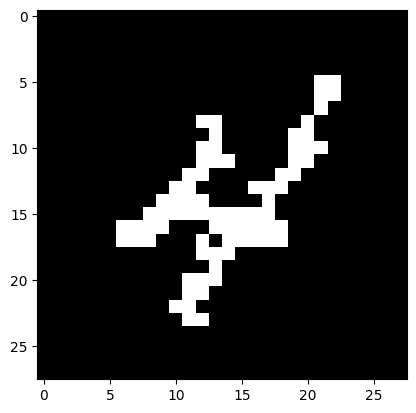

In [6]:
#Lets us visualize a number from the data set
idx = 9
img = mnist_data.train_data[idx]
print("The number shown is the number: {}".format(mnist_data.train_labels[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

In [7]:
# I have have set these hyper parameters although you can experiment with them to find better hyperparameters.
dbn_mnist = DBN(visible_units=28*28 ,
                hidden_units=[23*23 ,18*18] ,
                k = 5,
                learning_rate = 0.01,
                learning_rate_decay = True,
                xavier_init = True,
                increase_to_cd_k = False,
                use_gpu = False)

In [8]:
num_epochs = 2
batch_size = 10

dbn_mnist.train_static(mnist_data.train_data,mnist_data.train_labels,num_epochs , batch_size)

--------------------
Training the 1 st rbm layer
RBM fitting: 6000it [00:09, 634.90it/s]
Epoch:1 ,avg_cost = 0.5686710476875305 ,std_cost = 0.1099218875169754 ,avg_grad = 12043.4755859375 ,std_grad = 1995.6990966796875
RBM fitting: 6000it [00:09, 652.47it/s]
Epoch:2 ,avg_cost = 0.4669155180454254 ,std_cost = 0.04873447120189667 ,avg_grad = 10907.0908203125 ,std_grad = 569.651123046875
--------------------
Training the 2 st rbm layer
RBM fitting: 6000it [00:06, 865.88it/s]
Epoch:1 ,avg_cost = 1.611491322517395 ,std_cost = 0.17327696084976196 ,avg_grad = 12321.6025390625 ,std_grad = 523.319091796875
RBM fitting: 6000it [00:10, 581.82it/s]
Epoch:2 ,avg_cost = 1.4833598136901855 ,std_cost = 0.0994459018111229 ,avg_grad = 12187.2666015625 ,std_grad = 315.3227233886719


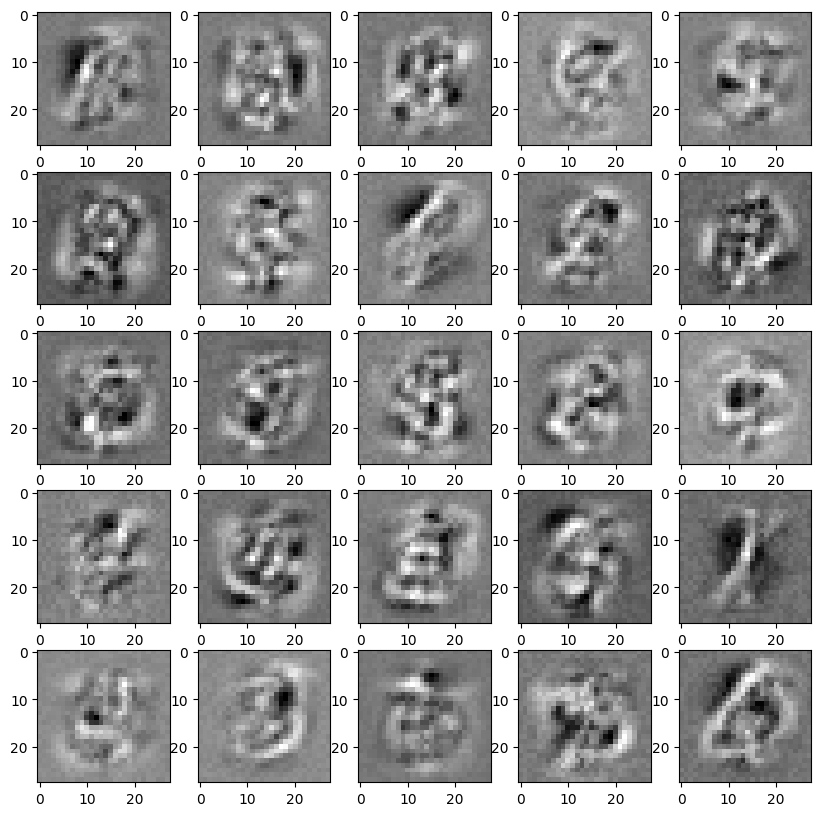

In [9]:
# visualising layer 1
learned_weights = dbn_mnist.rbm_layers[0].W.transpose(0,1).numpy()
plt.show()
fig = plt.figure(3, figsize=(10,10))
for i in range(25):
    sub = fig.add_subplot(5, 5, i+1)
    sub.imshow(learned_weights[i,:].reshape((28,28)), cmap=plt.cm.gray)
plt.show()

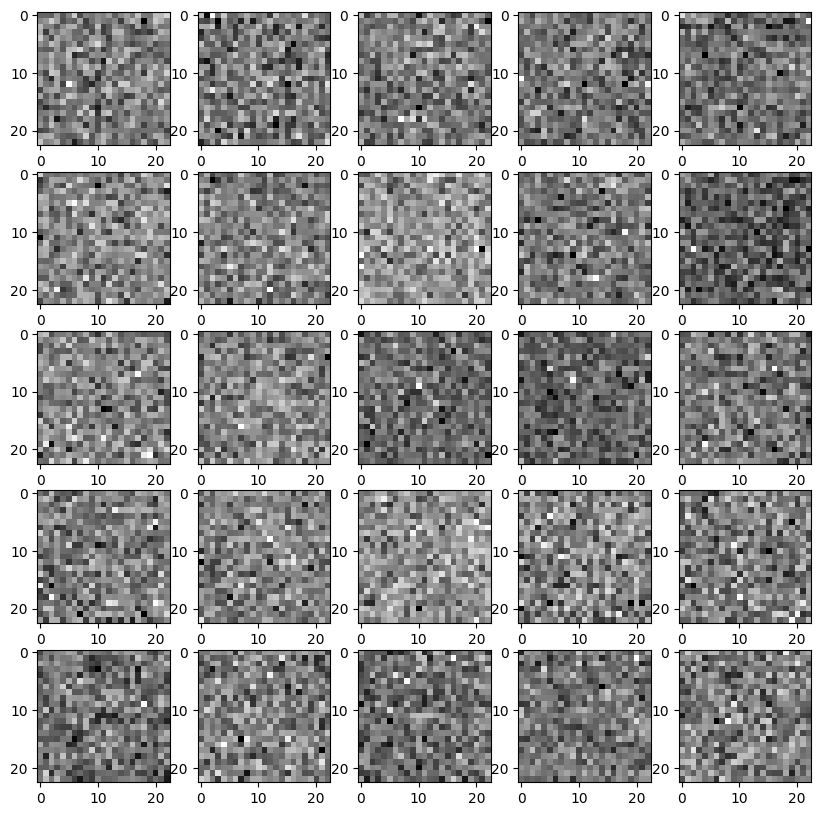

In [22]:
# visualising layer 2
learned_weights = dbn_mnist.rbm_layers[1].W.transpose(0,1).numpy()
plt.show()
fig = plt.figure(3, figsize=(10,10))
for i in range(25):
    sub = fig.add_subplot(5, 5, i+1)
    sub.imshow(learned_weights[i,:].reshape((23,23)), cmap=plt.cm.gray)
plt.show()

In [11]:
number = 5 #A number between 0 and 10.

particular_mnist = []

limit = mnist_data.train_data.shape[0]
# limit = 60000
for i in range(limit):
    if(mnist_data.train_labels[i] == number):
        particular_mnist.append(mnist_data.train_data[i].numpy())
# particular_mnist = np.array(particular_mnist)
len(particular_mnist)
# mnist_data.train_data

5421

In [12]:
train_data = torch.stack([torch.Tensor(i) for i in particular_mnist])
train_label = torch.stack([torch.Tensor(number) for i in range(len(particular_mnist))])

In [13]:
dbn_mnist.train_static(train_data,train_label,20 , batch_size)

--------------------
Training the 1 st rbm layer
RBM fitting: 542it [00:00, 604.67it/s]
Epoch:1 ,avg_cost = 0.49134111404418945 ,std_cost = 0.04154315963387489 ,avg_grad = 10794.365234375 ,std_grad = 528.9266357421875
RBM fitting: 542it [00:00, 592.45it/s]
Epoch:2 ,avg_cost = 0.4698982834815979 ,std_cost = 0.040339335799217224 ,avg_grad = 10591.2587890625 ,std_grad = 530.970947265625
RBM fitting: 542it [00:00, 615.80it/s]
Epoch:3 ,avg_cost = 0.46220219135284424 ,std_cost = 0.039986010640859604 ,avg_grad = 10589.4267578125 ,std_grad = 519.4892578125
RBM fitting: 542it [00:00, 662.20it/s]
Epoch:4 ,avg_cost = 0.45753392577171326 ,std_cost = 0.039577823132276535 ,avg_grad = 10604.6220703125 ,std_grad = 550.5548095703125
RBM fitting: 542it [00:00, 590.70it/s]
Epoch:5 ,avg_cost = 0.4534766376018524 ,std_cost = 0.03930777311325073 ,avg_grad = 10603.294921875 ,std_grad = 525.3577880859375
RBM fitting: 542it [00:00, 632.66it/s]
Epoch:6 ,avg_cost = 0.451754093170166 ,std_cost = 0.038965862244367

The original number: 3


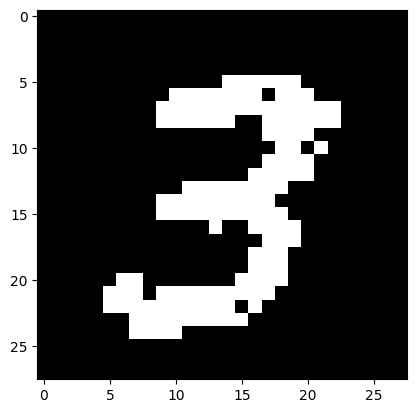

The reconstructed image


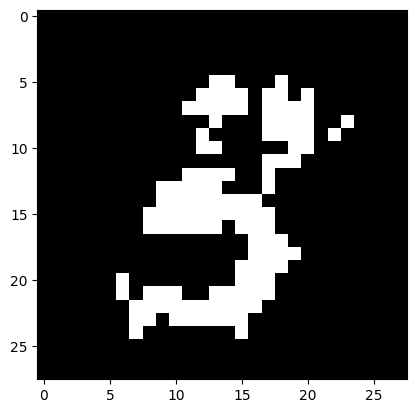

In [20]:
idx = 7
img = mnist_data.train_data[idx]
reconstructed_img = img.view(1,-1).type(torch.FloatTensor)

_,reconstructed_img= dbn_mnist.reconstruct(reconstructed_img)

reconstructed_img = reconstructed_img.view((28,28))
print("The original number: {}".format(mnist_data.train_labels[idx]))
plt.imshow(img , cmap = 'gray')
plt.show()
print("The reconstructed image")
plt.imshow(reconstructed_img , cmap = 'gray')
plt.show()